# Load Dataset

In [1]:
import numpy as np
import random
import math
import os
import scipy.io
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import transformers
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
from sklearn.preprocessing import StandardScaler

In [35]:
def convert_to_time(hmm):
    # Ensure elements are scalar ints (handles numpy objects)
    hmm = [int(x.item() if isinstance(x, np.ndarray) and x.size == 1 else int(x)) for x in hmm]
    year, month, day, hour, minute, second = hmm
    return datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)

def loadMat(matfile):
    data = scipy.io.loadmat(matfile)
    filename = matfile.split("/")[-1].split(".")[0]
    col = data[filename]
    col = col[0][0][0][0]
    size = col.shape[0]

    data_list = []
    for i in range(size):
        k = list(col[i][3][0].dtype.fields.keys())
        d1, d2 = {}, {}

        if str(col[i][0][0]) != 'impedance':
            for j in range(len(k)):
                t = col[i][3][0][0][j][0]
                l = [t[m] for m in range(len(t))]
                d2[k[j]] = l

        # Extract possible array values safely
        type_val = col[i][0][0]
        temp_val = col[i][1][0]
        time_val = col[i][2][0]  # 6-element array (year..sec)

        # Convert type and temp safely
        if isinstance(type_val, np.ndarray) and type_val.size == 1:
            type_val = type_val.item()
        if isinstance(temp_val, np.ndarray) and temp_val.size == 1:
            temp_val = temp_val.item()

        d1['type'] = str(type_val)
        d1['temp'] = int(temp_val)
        d1['time'] = str(convert_to_time(time_val))
        d1['data'] = d2

        data_list.append(d1)

    return data_list

# get input features (all columns except capacity)
def getBatteryInputs(Battery, feature_list=None, include_temp=True):
    """
    Returns inputs for all discharge cycles and the feature names.
    Automatically removes features that are constant across all batteries.
    """
    inputs = []

    # Determine initial feature list from first discharge cycle
    if feature_list is None:
        for Bat in Battery:
            if Bat['type'] == 'discharge':
                feature_list = list(Bat['data'].keys())
                if 'Capacity' in feature_list:
                    feature_list.remove('Capacity')
                break

    # Include temp if requested
    if include_temp:
        feature_list.append('temp')

    # Build a 2D array: rows = cycles across all batteries, cols = features
    all_data = []
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            row = []
            for f in feature_list:
                if f == 'temp':
                    row.append(Bat['temp'])
                else:
                    row.append(Bat['data'].get(f, [0])[0])
            all_data.append(row)
    all_data = np.array(all_data, dtype=np.float32)  # shape: (num_cycles_total, num_features)

    # Remove features that are constant (same value in all rows)
    is_constant = np.all(all_data == all_data[0, :], axis=0)
    cleaned_data = all_data[:, ~is_constant]
    cleaned_feature_list = [f for f, keep in zip(feature_list, ~is_constant) if keep]

    return cleaned_data, cleaned_feature_list

# get capacity data
def getBatteryCapacity(Battery):
    """
    Returns 1D array of capacity for all discharge cycles.
    """
    capacities = []
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            capacities.append(Bat['data']['Capacity'][0])
    return np.array(capacities, dtype=np.float32)
    

In [36]:
Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
dir_path = 'dataset/'

Battery_dict = {}
for name in Battery_list:
    print(f'Loading {name}')
    path = dir_path + name + '.mat'
    data = loadMat(path)

    X, feature_list = getBatteryInputs(data)      # inputs for discharge cycles
    y = getBatteryCapacity(data)    # capacity as target

    Battery_dict[name] = (X, y)

Loading B0005
Loading B0006
Loading B0007
Loading B0018


In [37]:
# Check shapes
battery_name = Battery_list[3]
print("Inputs shape:", Battery_dict[battery_name][0].shape)
print("Targets shape:", Battery_dict[battery_name][1].shape)
print(feature_list)

Inputs shape: (132, 4)
Targets shape: (132,)
['Voltage_measured', 'Current_measured', 'Temperature_measured', 'Current_load']


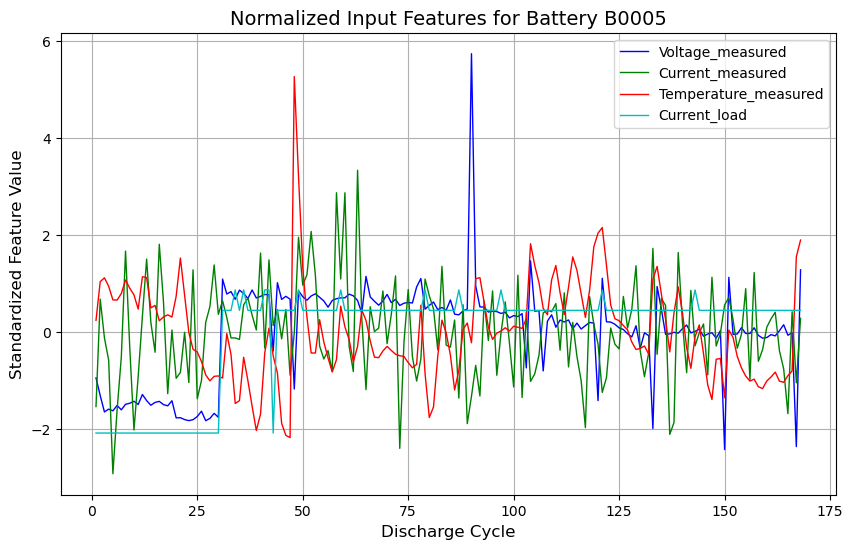

In [38]:
def plot_battery_features(battery_name, exclude_features=['Time']):
    """
    Plots all input features of a battery over discharge cycles.
    Features are standardized for better visualization.
    """
    # Get inputs and feature list
    X, y = Battery_dict[battery_name]  # shape: (num_cycles, num_features)
    feature_names = feature_list.copy()  # same list used to build X

    # Remove any excluded features
    for feat in exclude_features:
        if feat in feature_names:
            idx = feature_names.index(feat)
            X = np.delete(X, idx, axis=1)
            feature_names.pop(idx)
    
    # Standardize features for plotting
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    num_cycles, num_features = X_scaled.shape
    cycles = np.arange(1, num_cycles + 1)
    
    plt.figure(figsize=(10, 6))
    color_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    
    for i in range(num_features):
        color = color_list[i % len(color_list)]
        plt.plot(cycles, X_scaled[:, i], color=color, linewidth=1, label=feature_names[i])
    
    plt.xlabel('Discharge Cycle', fontsize=12)
    plt.ylabel('Normalized Feature Value', fontsize=12)
    plt.title(f'Normalized Input Features for Battery {battery_name}', fontsize=14)
    plt.grid(True)
    plt.legend(fontsize=10)
    plt.show()


# Example usage
plot_battery_features(Battery_list[0])

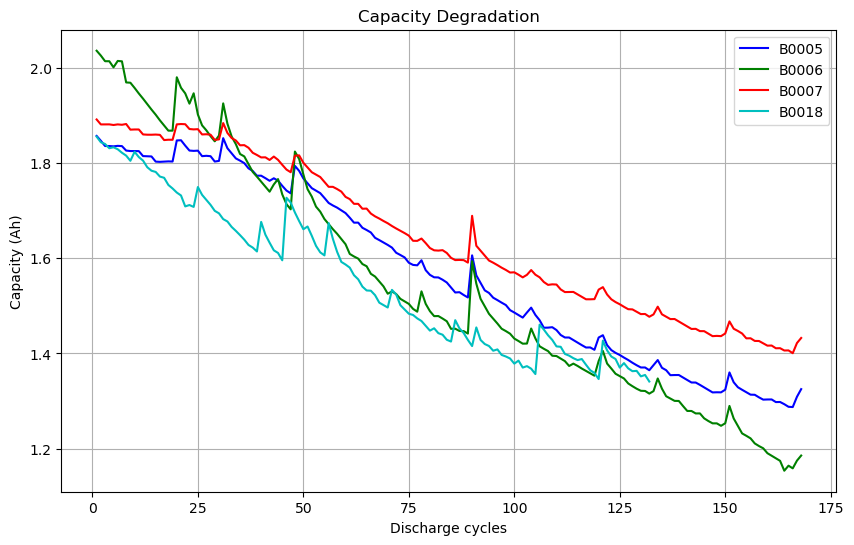

In [39]:
fig, ax = plt.subplots(figsize=(10, 6))  # slightly smaller than original
color_list = ['b', 'g', 'r', 'c', 'm', 'y']
for c, (name, color) in enumerate(zip(Battery_list, color_list)):
    X, y = Battery_dict[name]  # inputs and targets
    cycles = np.arange(1, len(y)+1)
    ax.plot(cycles, y, color=color, label=name)

ax.set_xlabel('Discharge cycles')
ax.set_ylabel('Capacity (Ah)')
ax.set_title('Capacity Degradation')
ax.grid(True)
ax.legend()
plt.show()

In [40]:
def build_instances_from_xy(X, y, window_size):
    """
    X: (num_cycles, num_features)
    y: (num_cycles,)
    Returns windowed sequences: (num_windows, window_size, num_features), (num_windows,)
    """
    x_windows, y_targets = [], []
    for i in range(len(y) - window_size):
        x_windows.append(X[i:i+window_size])
        y_targets.append(y[i+window_size])
    return np.array(x_windows, dtype=np.float32), np.array(y_targets, dtype=np.float32)


def split_dataset(data_sequence, train_ratio=0.8, capacity_threshold=0.0):
    """
    Split the sequence into training and testing data chronologically.
    Either based on a ratio (e.g. 0.8) or a capacity threshold (fraction of max capacity).
    """
    n = len(data_sequence)

    if capacity_threshold > 0:
        max_capacity = max(data_sequence)
        threshold_value = max_capacity * capacity_threshold
        # first point where capacity drops below threshold
        below = np.where(np.array(data_sequence) < threshold_value)[0]
        point = below[0] if len(below) > 0 else int(n * train_ratio)
    else:
        point = int(n * train_ratio)

    train_data = data_sequence[:point]
    test_data = data_sequence[point:]
    return list(train_data), list(test_data)


def get_train_test(data_dict, test_name, window_size=8, train_ratio=0.8):
    """
    Leave-one-out scheme:
      - `test_name` battery is reserved for testing
      - All other batteries + training portion of test battery used for training

    Returns:
        train_x: (num_train_windows, window_size, num_features)
        train_y: (num_train_windows,)
        test_x:  (num_test_windows, window_size, num_features)
        test_y:  (num_test_windows,)
    """
    # Extract test battery data
    X_test_full, y_test_full = data_dict[test_name]
    n_test = len(y_test_full)
    
    # Chronological split for test battery
    split_point = int(n_test * train_ratio)
    X_test_seq, y_test_seq = X_test_full[split_point:], y_test_full[split_point:]
    
    # Build sliding windows for test battery
    test_x, test_y = build_instances_from_xy(X_test_seq, y_test_seq, window_size)
    
    # Prepare training data
    train_x_list, train_y_list = [], []

    # Include training portion of test battery if long enough
    if split_point > window_size:
        X_train_seq, y_train_seq = X_test_full[:split_point], y_test_full[:split_point]
        tx, ty = build_instances_from_xy(X_train_seq, y_train_seq, window_size)
        train_x_list.append(tx)
        train_y_list.append(ty)
    
    # Include all other batteries
    for k, (X, y) in data_dict.items():
        if k != test_name:
            tx, ty = build_instances_from_xy(X, y, window_size)
            train_x_list.append(tx)
            train_y_list.append(ty)
    
    # Concatenate all training windows
    if train_x_list:
        train_x = np.vstack(train_x_list)
        train_y = np.hstack(train_y_list)
    else:
        train_x, train_y = np.empty((0, window_size, X_test_full.shape[1])), np.empty((0,))
    
    return train_x, train_y, test_x, test_y

In [41]:
train_x, train_y, test_x, test_y = get_train_test(
    data_dict=Battery_dict,
    test_name='B0018',
    window_size=8,
    train_ratio=0
)

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(480, 8, 4) (480,)
(124, 8, 4) (124,)


In [42]:
num_train_samples, seq_len, feat_dim = train_x.shape

# Initialize scaler for each feature
scaler = StandardScaler()

# Flatten to 2D: (num_samples * seq_len, num_features)
train_x_flat = train_x.reshape(-1, feat_dim)
scaler.fit(train_x_flat)

# Transform and reshape back
train_x = scaler.transform(train_x_flat).reshape(num_train_samples, seq_len, feat_dim)
test_x  = scaler.transform(test_x.reshape(-1, feat_dim)).reshape(test_x.shape)

# PyTorch Dataset
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = SequenceDataset(train_x, train_y)
test_dataset  = SequenceDataset(test_x, test_y)

# DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check shapes
for X_batch, y_batch in train_loader:
    print("Batch X:", X_batch.shape)  # (batch_size, window_size, num_features)
    print("Batch y:", y_batch.shape)  # (batch_size,)
    break

Batch X: torch.Size([32, 8, 4])
Batch y: torch.Size([32])
